In [1]:

#Uncomment following lines and edit path accordingly, if this script is not in same folder as the simtools folder
#import sys
#sys.path.insert(0, os.path.abspath('C:/path/to/folder_with_simtools-folder'))
import pickle
import os.path
import numpy as np
import pandas as pd
import tensorflow_addons as tfa
from math import exp

import glob

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from zipfile import ZipFile
from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


from sklearn import metrics
from sklearn.model_selection import cross_val_score


import pandas as pd 
import numpy as np 
import datetime
import tensorflow as tf

from tensorflow.keras import Model, Sequential, Input,models
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split

from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams


import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import glob
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator 

from scipy.optimize import curve_fit
''' setting the global parameters of matplotlib to academic puplication quality settings ''' 
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)


from functionen import *


In [2]:
'''

this Notebook get the Fit-Parameter for the Insta System for domestic Water heating


'''

'\n\nthis Notebook get the Fit-Parameter for the Insta System for domestic Water heating\n\n\n'

# Simulation data loading

In [7]:
path_ISA_csv = os.path.join(os.getcwd(),r'ISA Seriensimulation.csv')
path_sim_data_inst = os.path.join(os.getcwd(),r'Simulation Data\DF System')

In [8]:
buildings_inst3 = instaSystem_auswertung(path_ISA_csv,path_sim_data_inst)

100%|██████████| 120/120 [00:53<00:00,  2.22it/s]


# Gebüde Randbedieniungen SFH UND MFH VL 70 C°

In [9]:

'''
preparing the data for the fitting process:

resampling
zero Power out filtering
optional: include all the supply temperature profiles using the function alles
optional: choose one simulation run using i

'''

buildings_inst3 = insert_dcw(buildings_inst3)   #insert the cold water profile
Data = resampler_3auf15(buildings_inst3)    #resample the date from 3 minutes to 15 minutes
Data = null_leistung(Data,min_leistung_kw = 0.02)    # filtering out the points with near zero Heating power

Data = alles(Data,Data[0].columns,get_iterator(buildings_inst3,Ge = 0,step = 2)) #include all the simulations runs with the different supply temperature
i =0   #choose the simulation run
df = Data

 13%|█▎        | 8/60 [00:00<00:00, 78.41it/s]

0


100%|██████████| 60/60 [00:04<00:00, 14.77it/s]


In [10]:


cluster = zirkclust(df)  # create clusters according to the circulation time
df['cluster'] = cluster

'''
in this section the inputs will be loaded and the fit-parameter will be calculated using fitting_expo function.

'''
Tvl = np.array(df['T_ah_hot_in'])
dcw = np.array(df['dcw'])
x_data6 = np.array(df['dQ_DH']/df['dQ_DH'].max())
y_data6 = np.array(df['T_ph_hot_out'])

def fitting_expo(x_data,y_data):
    """

    this function calculate the fit parameter
    :param x_data: the inputs fot the fit (Q,supply temp Tvlp, dcw)
    :param y_data: the return temperature profile
    :return:
    y_predicted: predicted return temperature profile
    popt: Fit-Parameter
    func: the fit function
    """
    def func(X, a, b, c,d,f):
        Q,Tvl,dcw= X
        return a*np.exp(-b*Q)*Tvl**c + f
    popt, pcov = curve_fit(func, x_data, y_data,maxfev=1500)
    y_predicted = func(x_data,popt[0],popt[1],popt[2],popt[3],popt[4])
    return y_predicted,popt,func

y_prediction6,popt,func = fitting_expo((x_data6,Tvl,dcw),y_data6)
print(popt,len(y_prediction6))

#y_prediction6 = np.arange(len(zirk))




100%|██████████| 1583100/1583100 [00:01<00:00, 1442788.18it/s]


[ 5.65939827e+01  2.36387058e+01 -1.02168853e-02  1.00000000e+00
  1.37433361e+01] 1583100


In [11]:
#MAE , MSE, r2,accuracy,ab = evaluate(np.array(zirk['T_ph_hot_out']),y_prediction6)


In [12]:
'''
iterating through the profile of the return temperature to predict according to the cluster

'''

iterator = np.arange(len(df))
y_prediction6 = np.arange(len(df))
for i in tqdm(iterator):
    if cluster[i] == 1: #prediction when circulation is on
        y_prediction6[i] = func((x_data6[i],Tvl[i],dcw[i]),popt[0],popt[1],popt[2],popt[3],popt[4])

    elif cluster[i] == 0:
        y_prediction6[i] = dcw[i]  #prediction when circulation is off
        #y_prediction6[i] = func2(dcw2[i],popt2[0],popt2[1],popt2[2])


100%|██████████| 1583100/1583100 [00:04<00:00, 330730.20it/s]


In [13]:
MAE , MSE, r2,accuracy,ab = evaluate(np.array(df['T_ph_hot_out']),y_prediction6)


The model performance for testing set
--------------------------------------
MAE is 1.0359475647493208
MSE is 2.2218436715263987
MAPE is 0.026376079002365767
R2 score is 0.9765751815240987
95% percent of the data lay between ± 2.83


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


[<matplotlib.collections.PathCollection object at 0x0000026F058FBF10>, <matplotlib.collections.PathCollection object at 0x0000026F058FBFD0>] ['Trnsys Modell', 'Fitted Modell']
0
[<matplotlib.collections.PathCollection object at 0x00000270449066D0>, <matplotlib.lines.Line2D object at 0x0000027066952EE0>] ['gefittete Modell', 'Trnsys Modell ± 2.83 K']
0


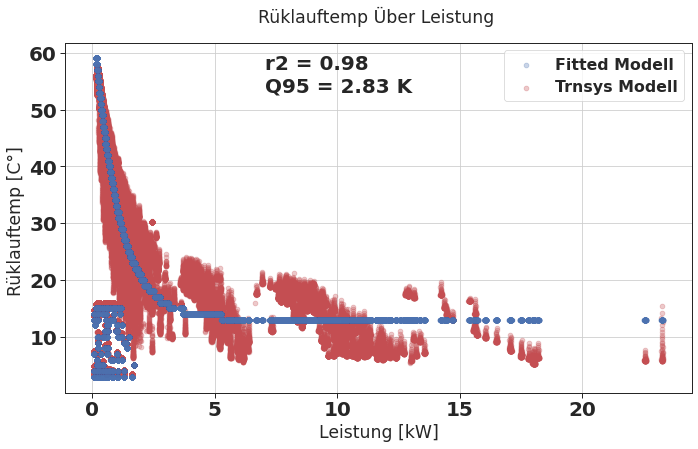

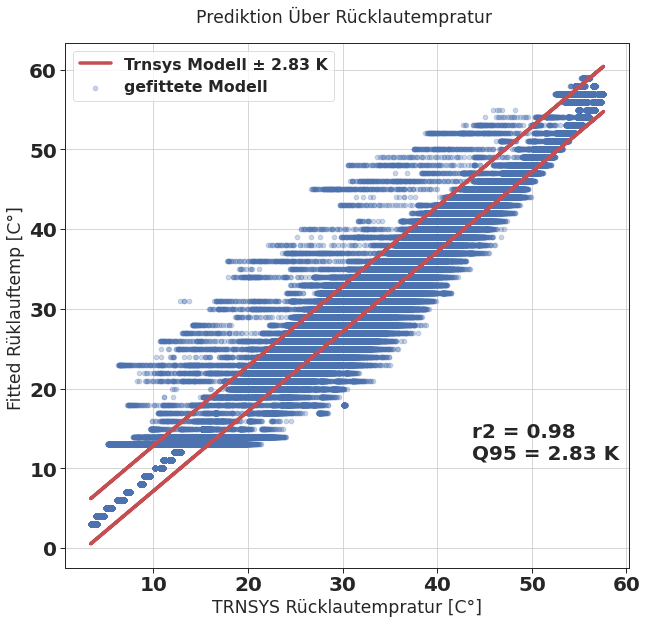

In [14]:

plot_prediction_q95(df['dQ_DH'],df['T_ph_hot_out'],y_prediction6,r2 = r2,q95 = accuracy[0])
plot_prediction(df['T_ph_hot_out'],df['T_ph_hot_out'],y_prediction6,r2 = r2,q95 = accuracy[0],figsize =(9,9))